In [35]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Pytorch
import torch
import torch.nn as nn  # NN; networks (CNN, RNN, losses)
import torch.optim as optim  # Optimizers (Adam, Adadelta, Adagrad)
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset  # Dataset manager
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler

from skimage.metrics import structural_similarity as ssim
import os
from tqdm import tqdm
from pathlib import Path


In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('❌CUDA is not available.  Training on CPU ...')
else:
    print('✔️CUDA is available!  Training on GPU ...')

✔️CUDA is available!  Training on GPU ...


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
!unzip -q /content/gdrive/MyDrive/NIR/data/images/train.zip
!unzip -q /content/gdrive/MyDrive/NIR/data/images/test.zip

In [16]:
IMAGES_DIR = Path("train/")
TEST_IMAGES_DIR = Path("test/")
DEVICE = torch.device("cuda")

In [6]:
print(os.listdir(IMAGES_DIR))
print(os.listdir(TEST_IMAGES_DIR))

['1.jpg',
 '10.jpg',
 '3.jpg',
 '6.jpg',
 '7.jpg',
 '4.jpg',
 '8.jpg',
 '9.jpg',
 '5.jpg',
 '2.jpg']

In [7]:
def add_noise(image, scale=0.2707):
    noise = np.random.rayleigh(scale=scale, size=image.size)
    # Add noise
    noised_img = image + image * noise
    noised_img = np.where(noised_img <= 255, noised_img, 255)
    return noised_img

In [8]:
RESCALE_SIZE = 608

class ImageDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.images_list = os.listdir(self.image_dir)

        self.x_transform = transforms.Compose([
            transforms.Grayscale(1),
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Lambda(add_noise),
            # transforms.Normalize(0.5, 0.5),
            transforms.Lambda(lambda x: x / 255),
            transforms.ToTensor(),
        ])
        self.y_transform = transforms.Compose([
            transforms.Grayscale(1),
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.images_list)
    
    def __getitem__(self, index):
        image = Image.open(self.image_dir / self.images_list[index])
        noised_image = self.x_transform(image).float()
        image = self.y_transform(image)

        return noised_image, image

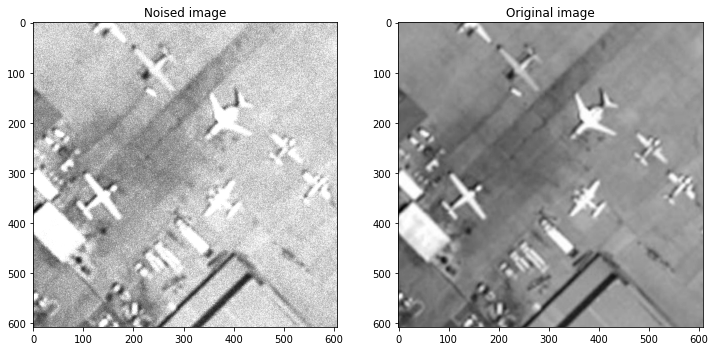

In [9]:
image_dataset = ImageDataset(IMAGES_DIR)
image_loader = DataLoader(image_dataset, batch_size=1, shuffle=True)
for X, y in image_loader:
    # print("x ", X)
    # print("y ", y)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
    # fig.figsize(12, 12)
    ax1.imshow(X[0][0], cmap="gray")
    ax1.set_title("Noised image")
    ax2.imshow(y[0][0], cmap="gray")
    ax2.set_title("Original image")
    break

In [106]:
class CNNModel_(nn.Module):
    def __init__(self, num_filter=4):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=4)
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=4)
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=8)
            )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16)
            )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32)
            )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64)
            )
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=1, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=1)
            )
    
    def forward(self, x):
        out1 = self.conv1(x)

        out2 = self.conv2(out1)
        out2 = torch.cat((out1, out2), dim=1)

        out3 = self.conv3(out2)
        out3 = torch.cat((out2, out3), dim=1)

        out4 = self.conv4(out3)
        out4 = torch.cat((out3, out4), dim=1)

        out5 = self.conv5(out4)
        out5 = torch.cat((out4, out5), dim=1)

        out6 = self.conv6(out5)
        out6 = torch.cat((out5, out6), dim=1)

        out7 = self.conv7(out6)
        return x


In [107]:
learning_rate = 0.005
EPOCHES = 40
BATCH_SIZE = 2
NUM_FILTERS = 3

image_dataset = ImageDataset(IMAGES_DIR)
image_loader = DataLoader(image_dataset, batch_size=BATCH_SIZE, shuffle=True)
model = CNNModel_(num_filter=NUM_FILTERS).to(device=DEVICE)

def train(image_loader, model):

    # criterion = nn.L1Loss(reduction='mean')
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    ssim_list = []
    for epoch in tqdm(range(EPOCHES)):
        for X, y in image_loader:
            X = X.to(device=DEVICE)
            y = y.to(device=DEVICE)

            output = model(X)
            # loss = torch.sqrt(criterion(output, y))
            loss = criterion(output, y)

            losses.append(loss.to("cpu").item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # return 1, 2

            for out, y in zip(output, y):
                image = out[0]
                target = y[0]
                ssim_list.append(ssim(image.detach().cpu().numpy(), target.detach().cpu().numpy()))
                
        # print(loss)
    return losses, ssim_list


In [ ]:
losses, ssim_list = train(image_loader, model)

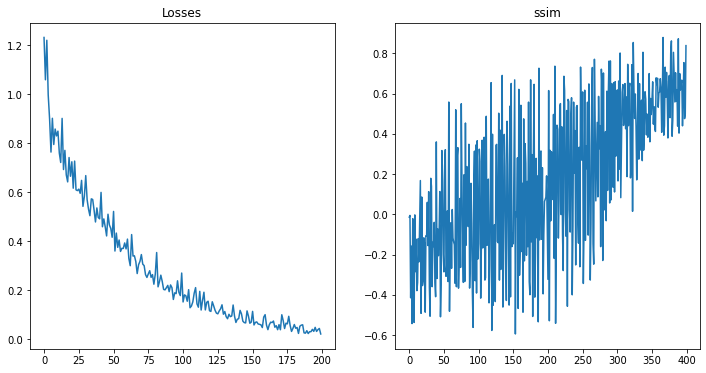

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(losses)
ax[0].set_title("Losses")
ax[1].plot(ssim_list)
ax[1].set_title("ssim");


In [65]:
def test_model(model):
    with torch.no_grad():
        model.eval()
        BATCH_SIZE = 1

        image_dataset = ImageDataset(IMAGES_DIR)
        image_loader = DataLoader(image_dataset, batch_size=BATCH_SIZE, shuffle=True)

        for _, image in image_loader:
            image = image.to(device=DEVICE)
            out = model(image)[0][0].to("cpu")
            plt.imshow(out, cmap="gray")
            break

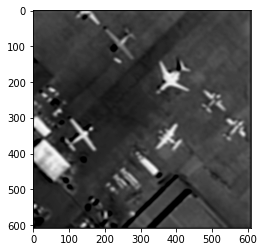

In [66]:
test_model(model)

In [79]:
bs, w, h = 2, 4, 4

x = torch.randn(bs, 3, w, h)
y = torch.randn(bs, 10, w, h)
z = torch.cat((x, y), dim=1)
z.size()

torch.Size([2, 13, 4, 4])